In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from skimage import io
import pydicom

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

## Load NIH data

In [2]:
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

## Load all image paths for later accessing images
path_regex = os.path.join('/','data', 'images_*', '*', '*.png')
all_image_paths = {os.path.basename(x): x for x in glob(path_regex)}

## Add path column for full image path
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

print('Total Headers', all_xray_df.shape[0], 'Total scans found:', len(all_image_paths))

Total Headers 112120 Total scans found: 112120


In [3]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png


In [4]:
# drop the Unnamed column
all_xray_df = all_xray_df.drop(columns=['Unnamed: 11'])

## Visualize Xray images

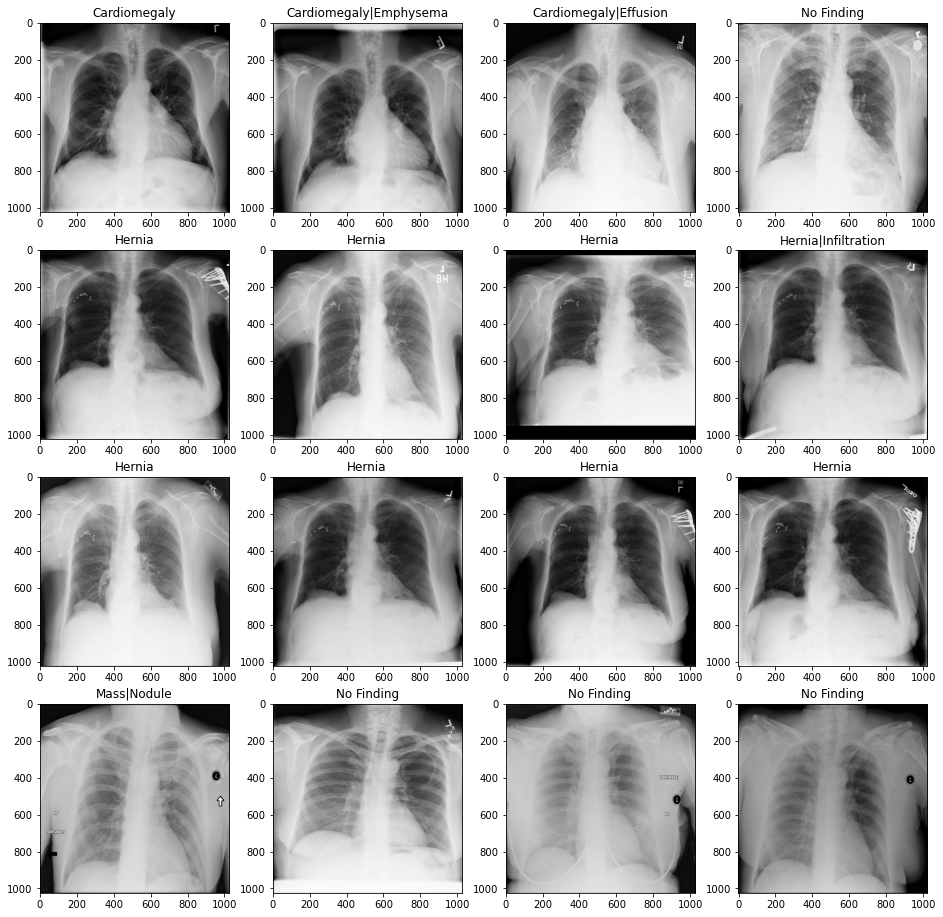

In [5]:
# Visualize medical images 
fig, m_axs = plt.subplots(4,4, figsize = (16, 16))
m_axs = m_axs.flatten()
img_indexes = all_xray_df['Image Index']
i = 0

for img_id, ax in zip(img_indexes, m_axs):
    img = io.imread(all_image_paths[img_id])
    ax.imshow(img,cmap='gray')
    ax.set_title(all_xray_df.iloc[i]['Finding Labels'])
    i += 1

## EDA

## Preprocessing Class Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels. 

Note that the percent of patients with Pneumonia in the entire population is fairly small, meaning that we have biased datasets. 

Text(0, 0.5, 'Images')

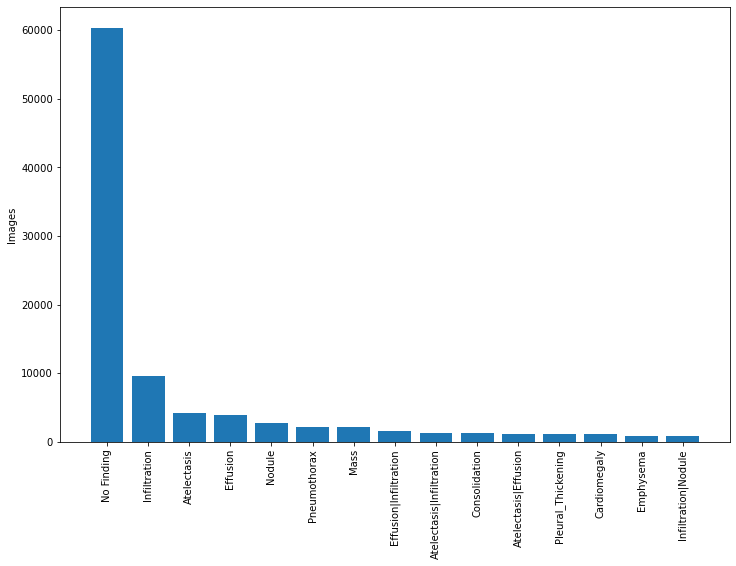

In [6]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

fig, ax = plt.subplots(1,1,figsize = (12, 8))
ax.bar(np.arange(len(label_counts))+0.5, label_counts)
ax.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax.set_xticklabels(label_counts.index, rotation = 90)
ax.set_ylabel('Images')

In [7]:
# onehotencoding                                   
all_disease_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_disease_labels = [x for x in all_disease_labels if len(x)>0 and 'No Finding' not in x]
print('All Labels ({}): {}'.format(len(all_disease_labels), all_disease_labels))

for c_label in all_disease_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
36774,00009689_010.png,No Finding,10,9689,55,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
5155,00001376_001.png,No Finding,1,1376,48,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
22900,00006044_003.png,No Finding,3,6044,39,F,PA,2048,2500,0.171,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# calculate % of patients with Pneumonia
pneumonia_perc = all_xray_df['Pneumonia'].sum()/len(all_xray_df)*100
print('Patients with Pneumonia account for {:0.2f} % of the dataset'.format(pneumonia_perc))

Patients with Pneumonia account for 1.28 % of the dataset


[Text(0, 0.5, 'Number of Images')]

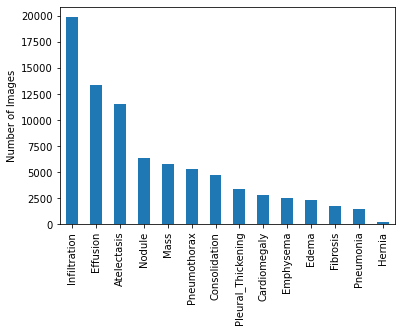

In [12]:
# count of images over labels distribution
ax = all_xray_df[all_disease_labels].sum().sort_values(ascending=False).plot(kind='bar')
ax.set(ylabel = 'Number of Images')

## Age 
Distribution of age over the entire data population vs over Pneumonia patient population are similar, with most concentration around 50-65 years old, peak around 60 years old. 

In [13]:
# remove invalid age 
print('Remove', len(all_xray_df[all_xray_df['Patient Age'] >= 120]), 'records with invalid age')
all_xray_df['Patient Age'] = np.clip(all_xray_df['Patient Age'], 5, 120)

Remove 16 records with invalid age


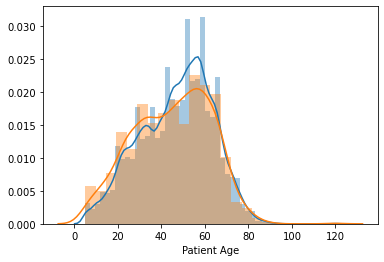

In [14]:
# check age histogram
sns.distplot(all_xray_df['Patient Age'])
sns.distplot(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'])

## Gender
There are more male than female in all samples and in all the patients who positive with Pneumonia.

M    0.56493
F    0.43507
Name: Patient Gender, dtype: float64
M/F: 1.30


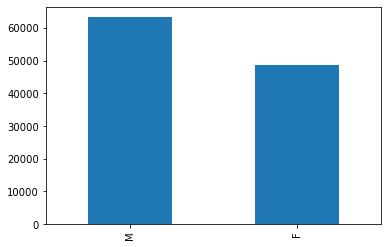

In [33]:
patient_gender = all_xray_df['Patient Gender']
patient_gender.value_counts().plot(kind='bar');
print(patient_gender.value_counts()/len(patient_gender))
print('M/F: {:0.2f}'.format( 0.56493/0.43507))

M    0.585604
F    0.414396
Name: Patient Gender, dtype: float64
M/F:1.41


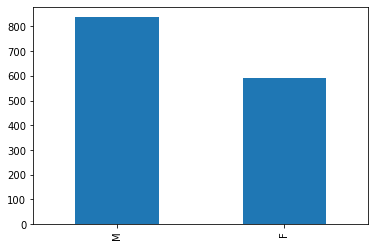

In [35]:
pneumonia_gender = all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender']
pneumonia_gender.value_counts().plot(kind='bar')
print(pneumonia_gender.value_counts()/len(pneumonia_gender))
print('M/F:{:0.2f}'.format(0.585604/0.414396))

## View Position
There are more patients with Pneumonia can be detected in AP position

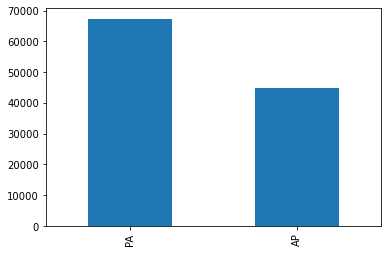

In [36]:
all_xray_df['View Position'].value_counts().plot(kind='bar')

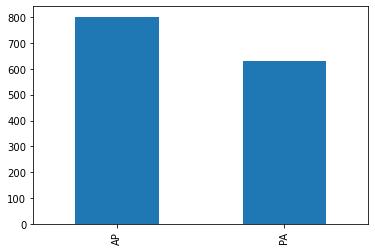

In [37]:
all_xray_df[all_xray_df.Pneumonia==1]['View Position'].value_counts().plot(kind='bar')

## The distribution of other diseases that are comorbid with pneumonia
It's likely that pneumonia is more likely to occur with Infiltration, Edema, Atelectasis. 

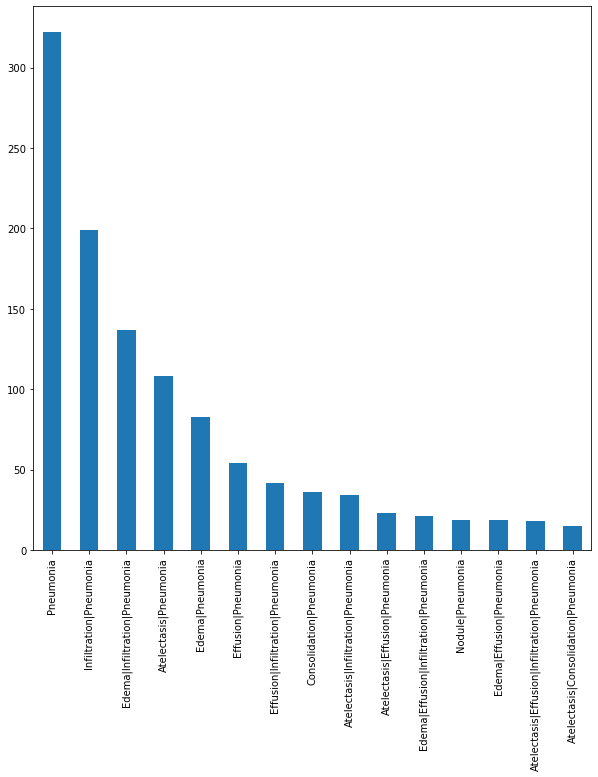

In [38]:
plt.figure(figsize=(10, 10))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:15].plot(kind='bar');

## Pixel-level assessments of the imaging data
We can see the difference in intensity of normal people scan and people with Pneumonia scan in area between 150-175



In [39]:
# Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.
# Loading the sample data
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1284,00006736_009.png,Atelectasis|Effusion,9,6736,052Y,M,PA,2500,2048,0.171,0.171
2426,00012163_002.png,No Finding,2,12163,052Y,M,PA,2992,2991,0.143,0.143
2953,00014525_025.png,No Finding,25,14525,056Y,M,AP,3056,2544,0.139,0.139


In [40]:
images = []
for i, img_id in enumerate(sample_df['Image Index']):
    path = glob(os.path.join('/data', 'images*', 'images', img_id))[0]
    img = io.imread(path)
    images.append(img)
print("Loaded {}/{}".format(len(images), len(sample_df)))

Loaded 5606/5606


In [41]:
images[0].shape

(1024, 1024)

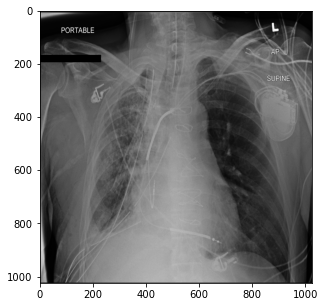

In [42]:
# checkout one image 
plt.figure(figsize=(5, 5))
plt.imshow(images[0], cmap='gray')

(array([8.0060e+03, 2.6750e+03, 9.3870e+03, 5.7800e+03, 8.4970e+03,
        4.8420e+03, 2.9400e+03, 2.6620e+03, 2.4830e+03, 2.3340e+03,
        2.3470e+03, 2.1130e+03, 1.9990e+03, 1.8000e+03, 1.8150e+03,
        1.8920e+03, 2.1080e+03, 1.9840e+03, 2.2790e+03, 2.5660e+03,
        2.7810e+03, 3.0020e+03, 3.1660e+03, 3.3690e+03, 3.6240e+03,
        3.5080e+03, 3.5220e+03, 3.8180e+03, 3.7190e+03, 3.9750e+03,
        4.1590e+03, 4.2630e+03, 4.4090e+03, 4.6070e+03, 4.7100e+03,
        4.9760e+03, 5.1290e+03, 5.1750e+03, 5.1480e+03, 5.1240e+03,
        4.9830e+03, 4.9170e+03, 4.8480e+03, 4.7830e+03, 4.8350e+03,
        4.8060e+03, 4.8580e+03, 4.6920e+03, 4.5850e+03, 4.3910e+03,
        4.3930e+03, 4.3860e+03, 4.3240e+03, 4.3620e+03, 4.1790e+03,
        4.2860e+03, 4.2930e+03, 4.3430e+03, 4.4170e+03, 4.7170e+03,
        4.7860e+03, 4.9150e+03, 4.9270e+03, 5.0610e+03, 5.1120e+03,
        5.0040e+03, 5.0820e+03, 5.4980e+03, 5.7430e+03, 6.1370e+03,
        6.4180e+03, 6.7260e+03, 6.7950e+03, 6.86

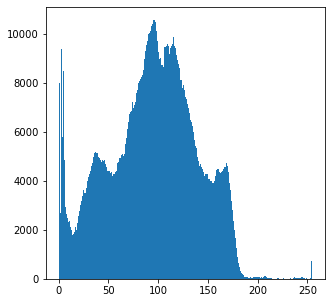

In [43]:
plt.figure(figsize=(5, 5))
plt.hist(images[0].ravel(), bins=256)

In [44]:
np.mean(img)

108.32167339324951

In [45]:
# Check intensity image for the one with pneumonia, infiltration and no finding
img_intensities = []
for i, img in enumerate(images): 
    img_intensities.append(np.mean(img))
    
print("Done {}/{}".format(i, len(images)))

Done 5605/5606


In [46]:
sample_df['intensity'] = img_intensities
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,intensity
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,93.601353
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,113.472080
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,156.328647
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,123.979362
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,157.159357


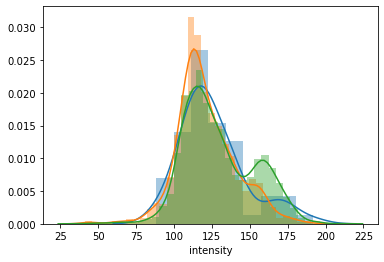

In [47]:
pneumonia_intensities = sample_df[sample_df['Finding Labels'].str.contains('Pneumonia')]['intensity']
infiltration_intensities = sample_df[sample_df['Finding Labels'].str.contains('Infiltration')]['intensity']
no_finding_intensities = sample_df[sample_df['Finding Labels'].str.contains('No Finding')]['intensity']

sns.distplot(pneumonia_intensities, label="Pneumonia")
sns.distplot(infiltration_intensities, label="Infiltration")
sns.distplot(no_finding_intensities, label="No Finding")